<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/0330%20session_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question
Create a classifier that achieves a higher f1_macro score than the Random Forest model we learned in the session (Random Forest f1_macro score = 0.624).

#import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import random
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [4]:
def seed_everything(seed):
    random.seed(seed)  #set a seed value for the Python random number generator
    os.environ['PYTHONHASHSEED'] = str(seed)  #set the environment variable PYTHONHASHSEED to the specified seed value
                                                #This affects the hash seed used by Python's built-in hash() function
    np.random.seed(seed)  #set the seed for the random number generator

seed_everything(42)

#About Dataset

In [6]:
train = pd.read_csv('/content/drive/MyDrive/BADA/0330 Machine Learning Practice/train_data.csv', sep=','); train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,54,self-employed,single,tertiary,no,384,no,yes,cellular,27,may,200,1,-1,0,unknown,yes
1,30,management,single,tertiary,no,17,no,no,cellular,28,aug,95,6,-1,0,unknown,no
2,38,admin.,married,secondary,no,0,yes,no,unknown,23,may,353,2,-1,0,unknown,no
3,42,technician,married,secondary,no,0,no,no,cellular,30,jul,351,2,-1,0,unknown,no
4,70,retired,married,secondary,no,0,no,no,cellular,27,oct,258,1,92,5,success,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,39,blue-collar,married,primary,no,1397,yes,no,unknown,12,jun,10,1,-1,0,unknown,no
36164,42,entrepreneur,married,primary,no,558,yes,no,cellular,6,may,186,2,-1,0,unknown,no
36165,35,admin.,divorced,secondary,no,-218,no,yes,cellular,31,jul,123,4,-1,0,unknown,no
36166,42,management,single,tertiary,no,515,yes,no,cellular,19,nov,501,2,-1,0,unknown,no


- direct marketing campaigns (phone calls) of a Portuguese banking institution
- Goal: to predict if the client will subscirbe to a term deposit(variable y)

### Column Descriptions

- balance : average yearly balance, in euros

- contact : contact communication type

- day : last contact day of the month

- month : last contact month of year

- duration : last contact duration, in seconds

- campaign : number of contact performed during this campaign and for this client

- pdays : number of days that passed by after the client was last contacted from a previous campaign. -1 means client was not previously contacted

- poutcome : outcome of the previous marketing campaign

In [10]:
print('----------------DF Shape-----------------\n')
print('number of data points:', train.shape[0])
print('number of variables:', train.shape[1])

print('\n---------------DF Summary----------------\n')
print(train.info())
print(train.describe())

print('\n---------------Unique Values-------------\n')
unique_list = {}
for col in train.columns:
    if train[col].dtype == 'O':
        unique_list[col] = train[col].unique()
print(unique_list)

print('\n---------------Missing Values-------------\n')
print(train.isnull().sum())

----------------DF Shape-----------------

number of data points: 36168
number of variables: 17

---------------DF Summary----------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  y          36168 non-null  object
dtypes: in

#Distribution of "y"

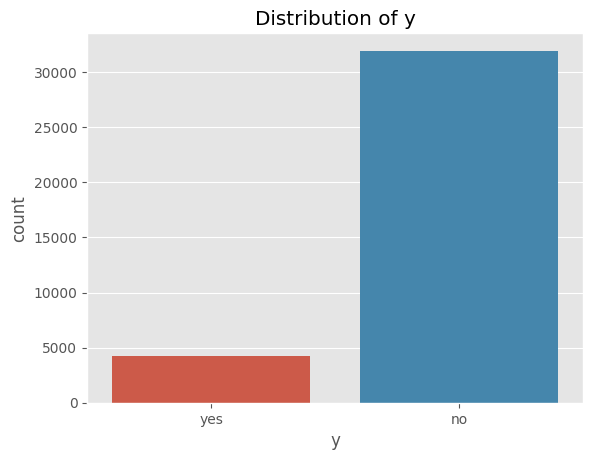

In [11]:
sns.countplot(x='y', data=train)
plt.title('Distribution of y')
plt.show()

😩 Unbalanced target variable

#Data Visualization

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(120, 80))

columns = list(train.columns)[:-1]
x = np.sqrt(len(columns))

for i in range(int(x)):
    for j in range(int(x)):
        col = columns.pop()

        if train[col].dtype != 'object':
            data = train.assign(quantile = pd.qcut(train[col].rank(method='first'), q=10))
            sns.countplot(data=data, x='quantile', hue='y', ax=ax[i,j]).set(xlabel=col)

        else:
            sns.countplot(data=train, x=col, hue='y', ax=ax[i,j])

fig.show()

In [13]:
def graph(col):
    plt.figure(figsize=(12,6))

    if col == 'pdays':
        plt.xlim(-1, train[col].max())

    sns.countplot(data=train, x=col)
    plt.title(f'Distribution of [{col}]')

    plt.show()

##previous

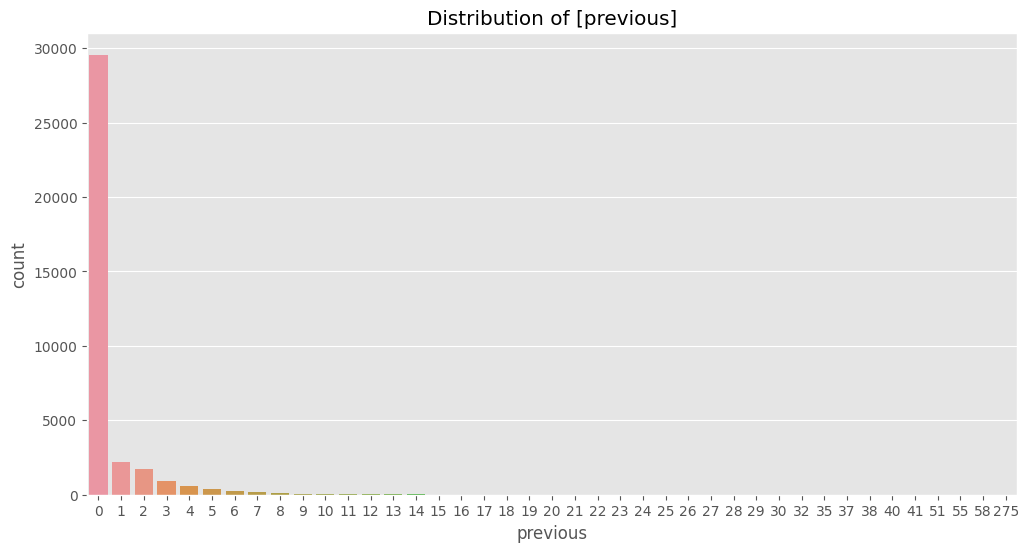

In [14]:
graph('previous')

In [7]:
#275 is too large compared to 58.
#So, let's change 275 to 60, a value that is close to 58 but slightly larger.
train.loc[train['previous']==275, 'previous'] = 60
len(train.loc[train['previous']==275])

0

##pdays

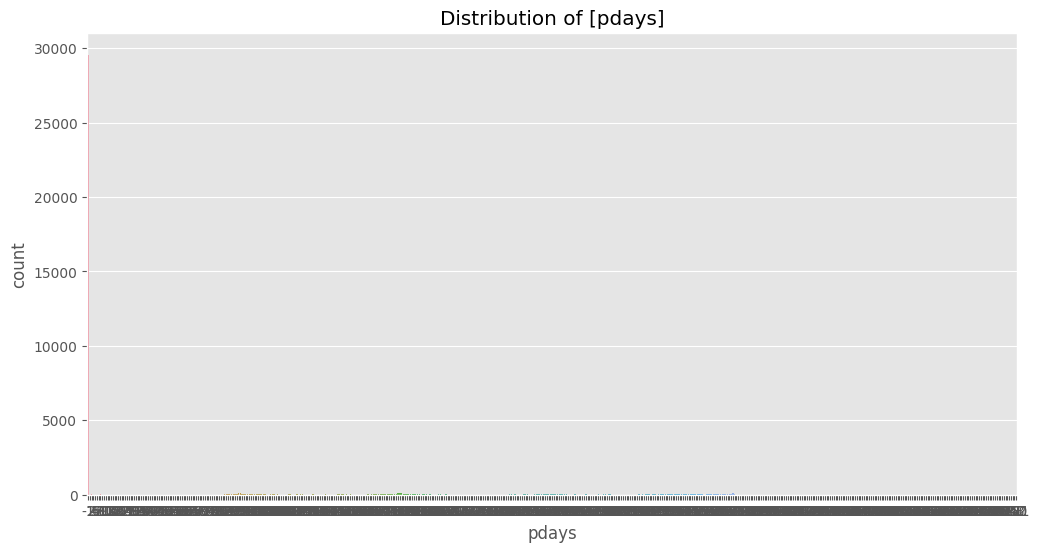

In [16]:
graph('pdays')

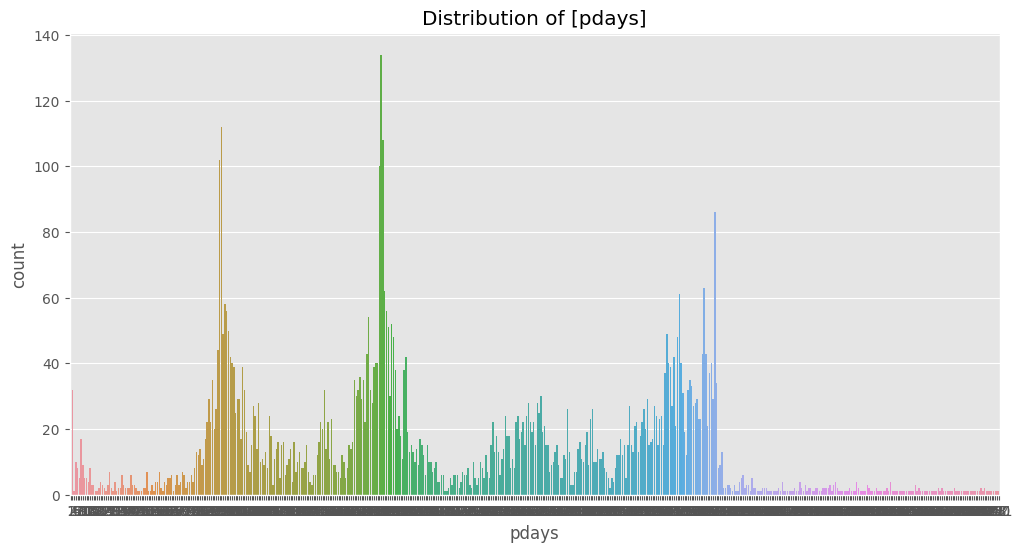

In [17]:
#There are too many -1 values, which cause the graph to be distorted.
#So, let's plot the graph using only the remaining values excluding -1.
data = train.loc[train['pdays']>-1]

plt.figure(figsize=(12,6))
sns.countplot(data=data, x='pdays')
plt.title('Distribution of [pdays]')
plt.show()

##campaign

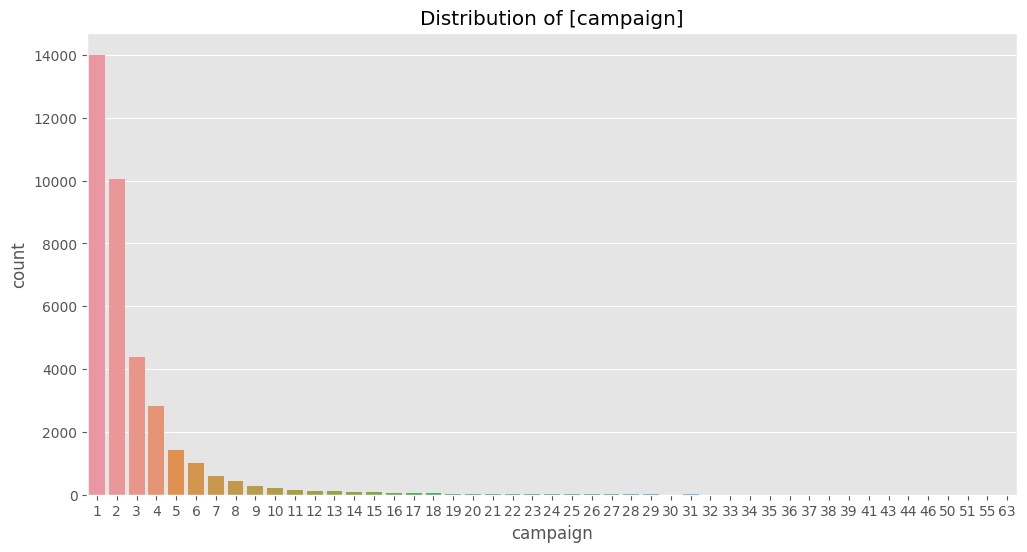

In [18]:
graph('campaign')

##duration

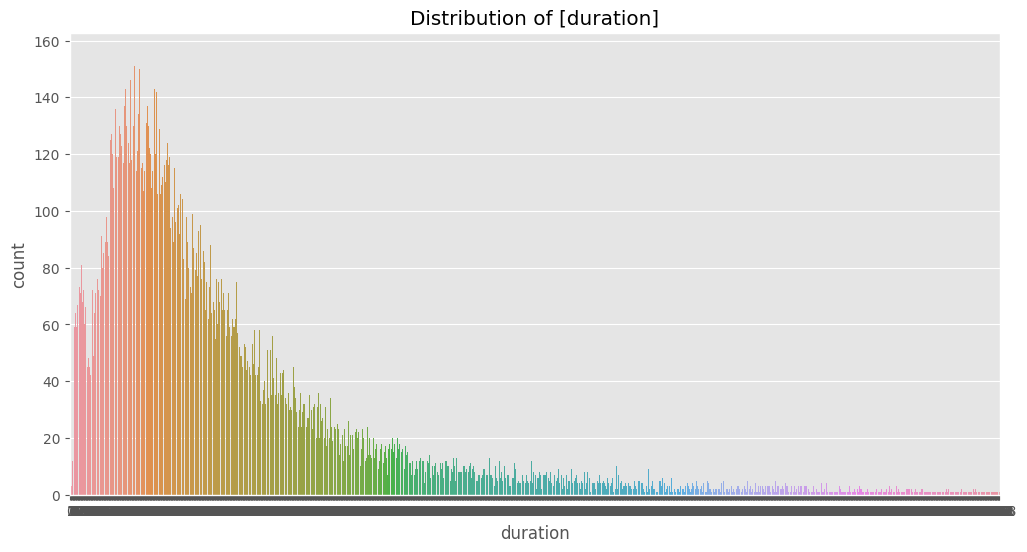

In [19]:
graph('duration')

##day

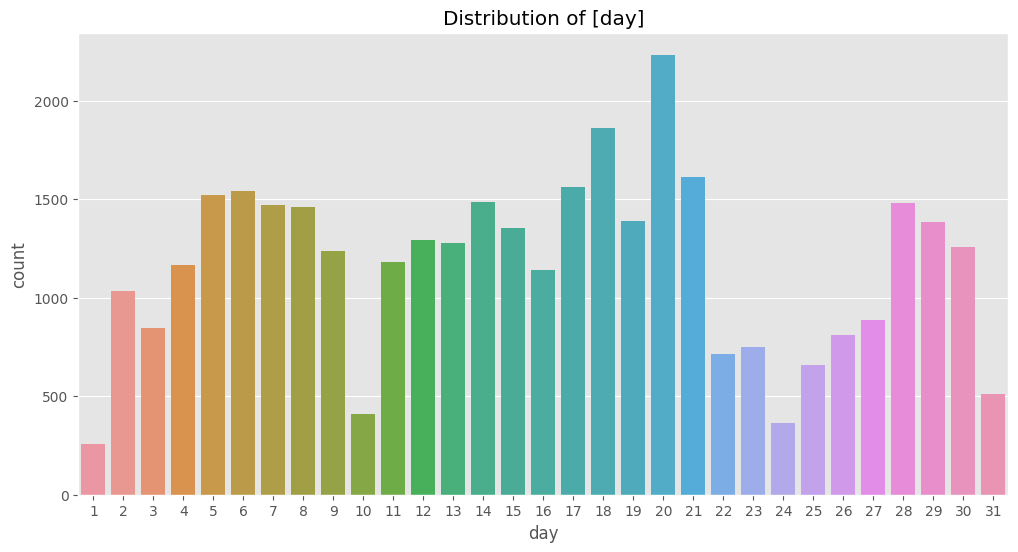

In [20]:
graph('day')

##balance

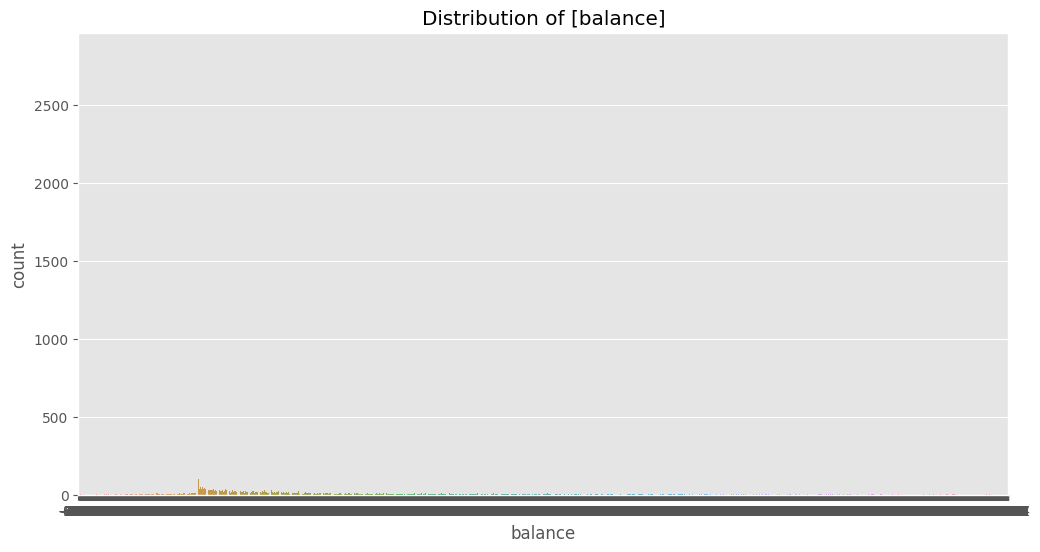

In [22]:
graph('balance')

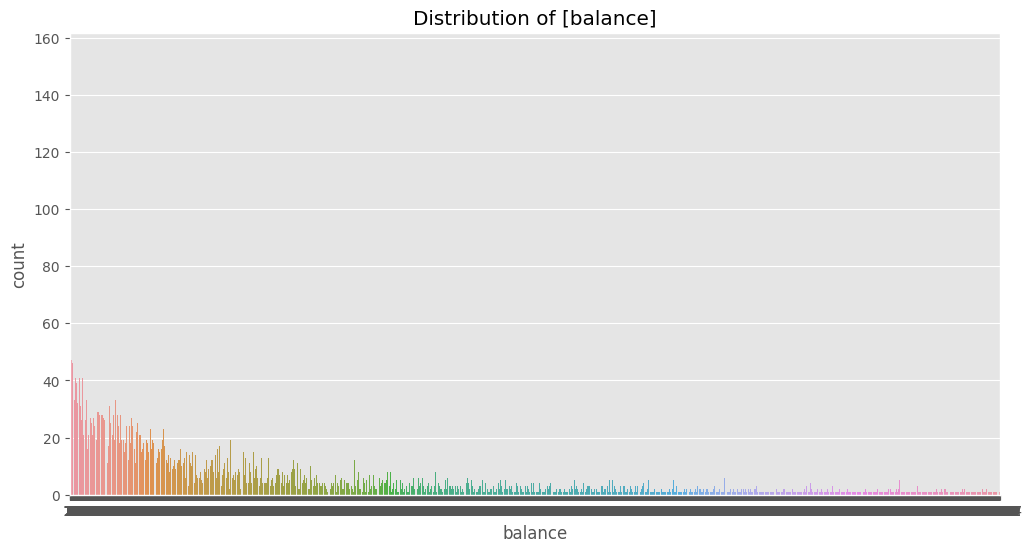

In [23]:
#Let's plot the graph using only positive values of the variable.
data = train.loc[train['balance']>0]

plt.figure(figsize=(12,6))
sns.countplot(data=data, x='balance')
plt.title('Distribution of [balance]')
plt.show()

##age

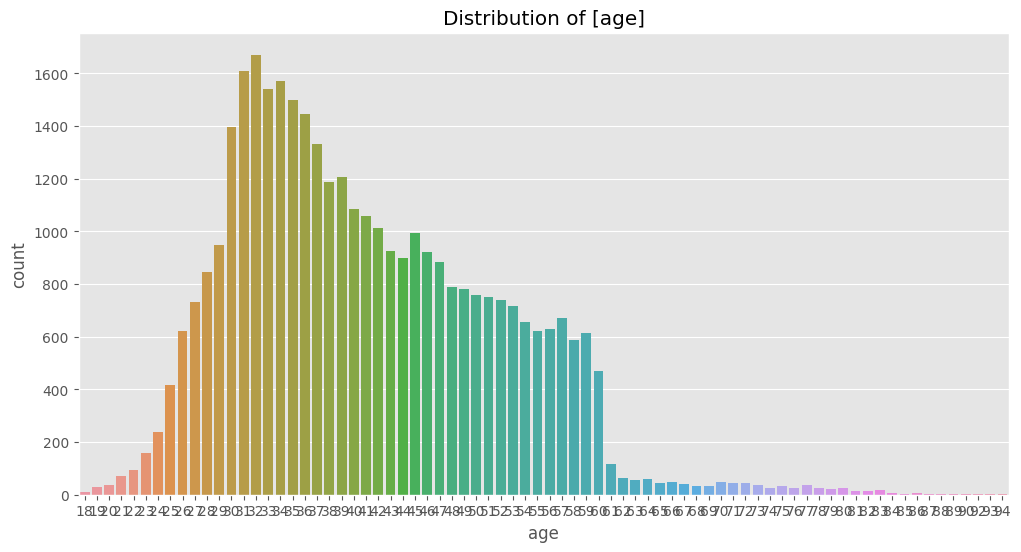

In [24]:
graph('age')

##Boxplot

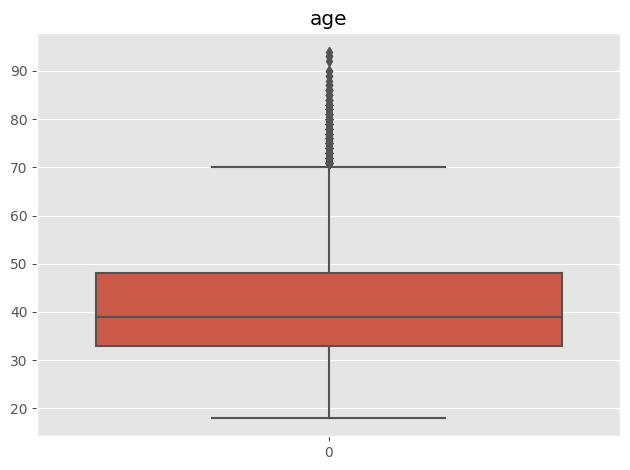

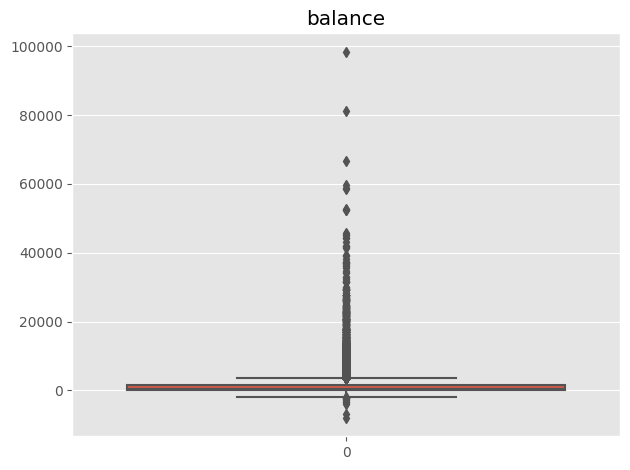

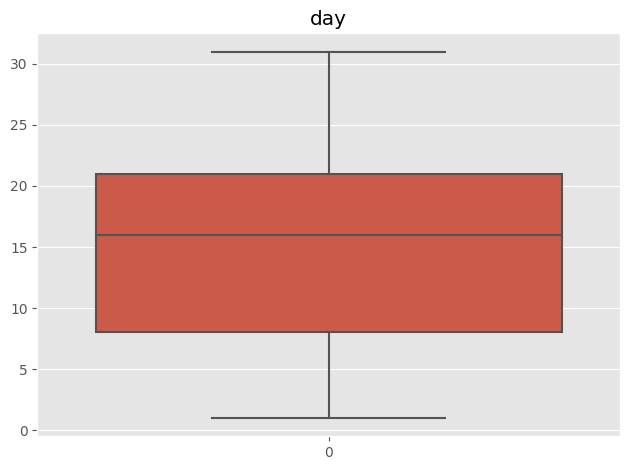

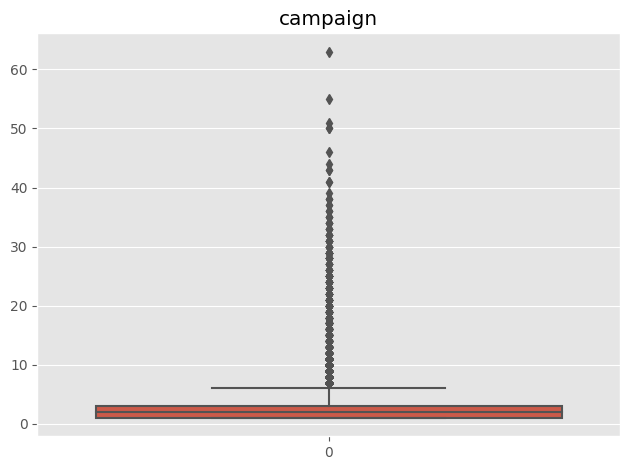

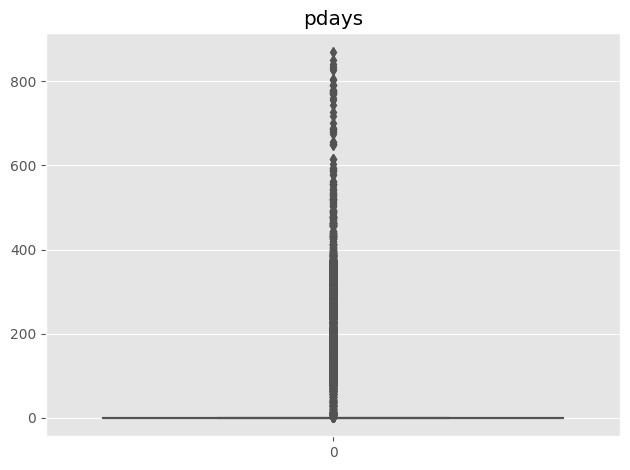

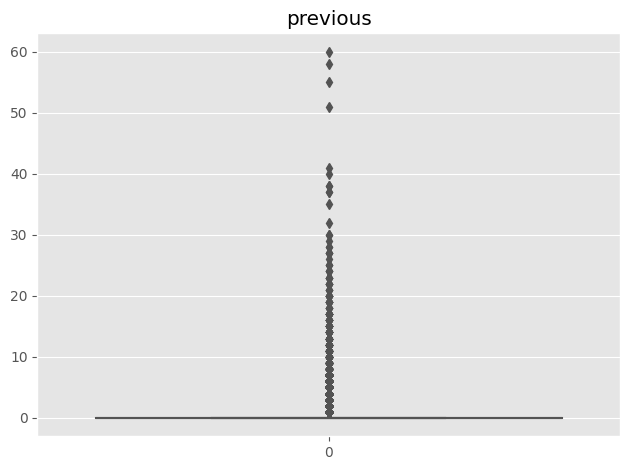

In [27]:
x = list(train.columns)[:-1]
for col in x:
    if train[col].dtype != 'object':
        sns.boxplot(train[col])
        plt.title(col)
        plt.tight_layout()
        plt.show()

# Remove "Duration"

Based on the visualization, longer duration is associated with more subscriptions. Our goal is to predict subscriptions, but we can only obtain information about the duration after the call ends. Therefore, this variable is not useful for predicting favorable customers.

In [8]:
train.drop(['duration'], axis=1, inplace=True)

#LabelEncoding

In [9]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

le = LabelEncoder()

for col in categorical_cols:
    train[col] = le.fit_transform(train[col])

In [30]:
train.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,54,6,2,2,0,384,0,1,0,27,8,1,-1,0,3,1


#train_test_split

In [10]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#Fitting XGBoost with GridSearchCV

##1. scale_pos_weight

In training a model on a dataset with imbalanced class distribution, "scale_pos_weight" can adjust the weights between the positive and negative classes.

In [35]:
positive_ratio = (y == 1).sum() / len(y)
scale_pos_weight = 1 / positive_ratio

model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, n_jobs=1, scoring='f1_macro')
print('K-fold mean f1 score = %.3f' % np.mean(scores))

K-fold mean f1 score = 0.657


In [36]:
model = XGBClassifier(scale_pos_weight=8, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, n_jobs=1, scoring='f1_macro')
print('K-fold mean f1 score = %.3f' % np.mean(scores))

K-fold mean f1 score = 0.664


In [38]:
model = XGBClassifier(scale_pos_weight=6, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, n_jobs=1, scoring='f1_macro')
print('K-fold mean f1 score = %.3f' % np.mean(scores))

K-fold mean f1 score = 0.684


In [39]:
#define grid
weights = [1, 2, 3, 4, 5, 6]
param_grid = dict(scale_pos_weight=weights)

#define model
model = XGBClassifier(random_state=42)

#define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro')
grid.fit(X, y)
best = grid.best_estimator_
params = grid.best_params_
scores = grid.best_score_
print(params, scores)

{'scale_pos_weight': 4} 0.6966772595675048


##2. min_child_weight, max_depth, colsample_bytree, subsample

- min_child_weight : the minimum sum of instance weight needed in a child node

- max_depth : the maximum depth of a tree

- colsample_bytree : the proportion of randomly selected features to be considered in building each decision tree

- subsample : the fraction of the dataset used for training each individual tree

In [41]:
#define grid
param_grid = {
    'min_child_weight' : np.arange(1, 5, 1),
    'max_depth' : np.arange(3,9,1),
    'colsample_bytree' : np.arange(0.5, 1.0, 0.1),
    'subsample' : np.arange(0.8, 1.0, 0.1)
    }

#define model
model = XGBClassifier(scale_pos_weight=4, random_state=42)

#define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro',
                    error_score='raise')
grid.fit(X, y)
best = grid.best_estimator_
params = grid.best_params_
scores = grid.best_score_
print(params, scores)

{'colsample_bytree': 0.6, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9} 0.7029755880414734


##3. eta

the learning rate or the step size at which the gradient boosting algorithm makes updates to the model's weights during each iteration

In [42]:
#define grid
param_grid = {
    'eta' : np.arange(0.01, 0.31, 0.03),
    'min_child_weight' : [2],
    'max_depth' : [4],
    'colsample_bytree' : [0.6],
    'subsample' : [0.9]
    }

#define model
model = XGBClassifier(scale_pos_weight=4, random_state=42)

#define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro',
                    error_score='raise')
grid.fit(X, y)
best = grid.best_estimator_
params = grid.best_params_
scores = grid.best_score_
print(params, scores)

{'colsample_bytree': 0.6, 'eta': 0.16, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9} 0.7028899723576761


##4. n_estimators

the number of boosting rounds or iterations

In [13]:
#define grid
param_grid = {
    'n_estimators' : np.arange(100, 501, 100),
    'eta' : [0.16],
    'min_child_weight' : [2],
    'max_depth' : [4],
    'colsample_bytree' : [0.6],
    'subsample' : [0.9]
    }

#define model
model = XGBClassifier(scale_pos_weight=4, random_state=42)

#define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_macro',
                    error_score='raise')
grid.fit(X, y)
best = grid.best_estimator_
params = grid.best_params_
scores = grid.best_score_
print(params, scores)

{'colsample_bytree': 0.6, 'eta': 0.16, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.9} 0.7044616070381574


#Final XGBoost Model

In [15]:
xgb_model = XGBClassifier(scale_pos_weight = 4,
                          random_state = 42,
                          n_estimators = 300,
                          eta = 0.16,
                          min_child_weight = 2,
                          max_depth = 4,
                          colsample_bytree = 0.6,
                          subsample = 0.9)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(xgb_model, X, y, cv=cv, n_jobs=-1, scoring='f1_macro')
print('K-fold mean f1 score = %.3f' % np.mean(scores))

K-fold mean f1 score = 0.704


Our f1_score is higher than Random Forest Model of the session!🥰

In [26]:
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.16, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

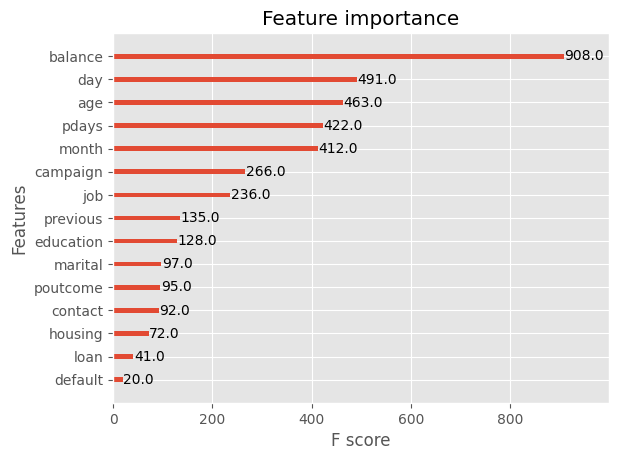

In [27]:
plot_importance(xgb_model)

<Axes: >

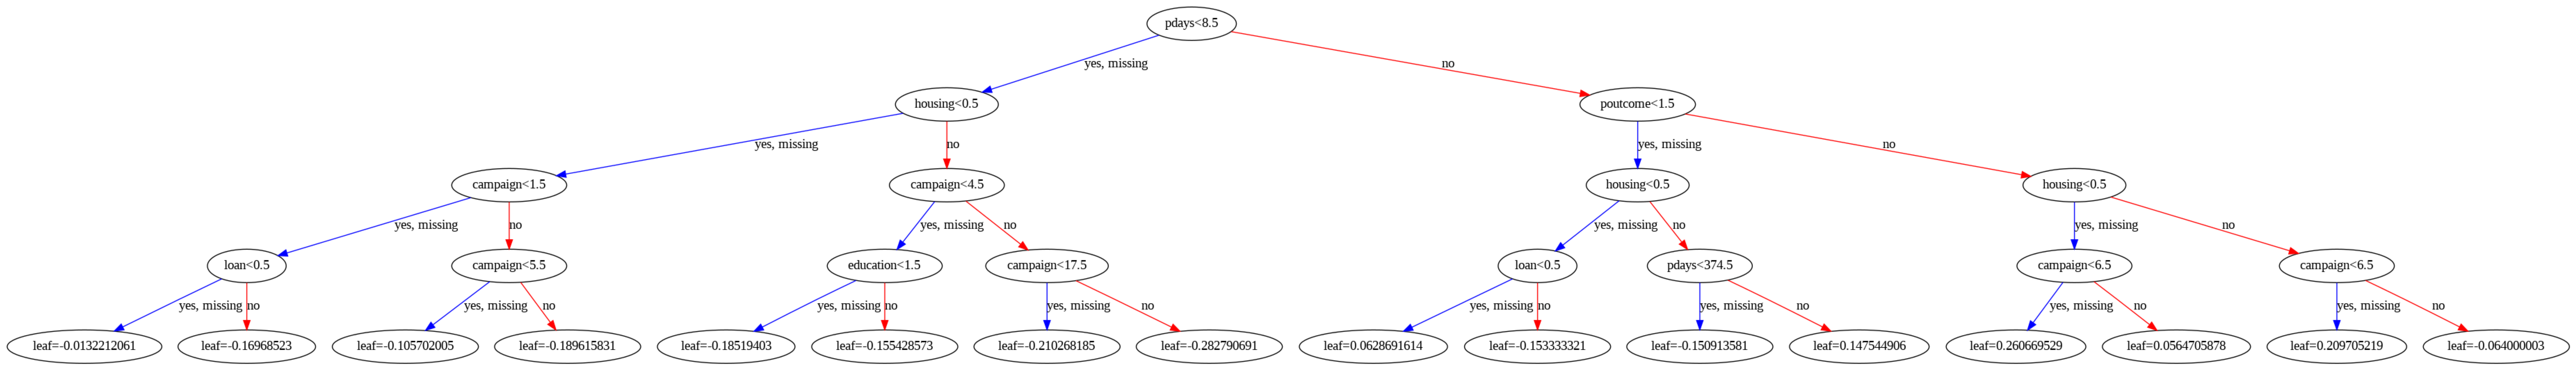

In [41]:
tree_index = 0  #Index of a individual tree that we want to visualize
plt.rcParams['figure.figsize'] = [90, 80]
plot_tree(xgb_model, num_trees=tree_index)

# Column Descriptions Citation
https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets
